# Car Segmentation with Agglomerative hierarchical clustering 
Imagine that an automobile manufacturer has developed prototypes for a new vehicle. Before introducing the new model into its range, the manufacturer wants to determine which existing vehicles on the market are most like the prototypes--that is, how vehicles can be grouped, which group is the most similar with the model, and therefore which models they will be competing against.

Our objective here, is to use clustering methods, to find the most distinctive clusters of vehicles. It will summarize the existing vehicles and help manufacturers to make decision about the supply of new models.

## Library


In [41]:
import numpy as np 
import pandas as pd
import scipy
import pylab
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

## Dowmloadin data
To download the data, we will use **`!wget`** to download it from IBM Object Storage.

In [1]:
!wget -O cars_clus.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%204/data/cars_clus.csv

--2024-05-15 15:02:58--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%204/data/cars_clus.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17774 (17K) [text/csv]
Saving to: 'cars_clus.csv'

     0K .......... .......                                    100% 2.30M=0.007s

2024-05-15 15:03:05 (2.30 MB/s) - 'cars_clus.csv' saved [17774/17774]



## Read data

In [15]:
df = pd.read_csv('cars_clus.csv')
print('Shape of dataset is:', df.shape)
df[0:5]

Shape of dataset is: (159, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.000,21.500,1.800,140.000,101.200,67.300,172.400,2.639,13.200,28.000,2.828,0.0
1,Acura,TL,39.384,19.875,0.000,28.400,3.200,225.000,108.100,70.300,192.900,3.517,17.200,25.000,3.673,0.0
2,Acura,CL,14.114,18.225,0.000,$null$,3.200,225.000,106.900,70.600,192.000,3.470,17.200,26.000,2.647,0.0
3,Acura,RL,8.588,29.725,0.000,42.000,3.500,210.000,114.600,71.400,196.600,3.850,18.000,22.000,2.150,0.0
4,Audi,A4,20.397,22.255,0.000,23.990,1.800,150.000,102.600,68.200,178.000,2.998,16.400,27.000,3.015,0.0


## Data Cleaning
Let's clean the dataset by dropping the rows that have null value:

In [16]:
df.dtypes

manufact      object
model         object
sales         object
resale        object
type          object
price         object
engine_s      object
horsepow      object
wheelbas      object
width         object
length        object
curb_wgt      object
fuel_cap      object
mpg           object
lnsales       object
partition    float64
dtype: object

In [17]:
print ("Shape of dataset before cleaning: ", df.shape)
df[[ 'sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']] = df[['sales', 'resale', 'type', 'price', 'engine_s',
       'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap',
       'mpg', 'lnsales']].apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df = df.reset_index(drop=True)
print ("Shape of dataset after cleaning: ", df.shape)
df.head(5)

Shape of dataset before cleaning:  (159, 16)
Shape of dataset after cleaning:  (117, 16)


,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0


In [18]:
df.dtypes

manufact      object
model         object
sales        float64
resale       float64
type         float64
price        float64
engine_s     float64
horsepow     float64
wheelbas     float64
width        float64
length       float64
curb_wgt     float64
fuel_cap     float64
mpg          float64
lnsales      float64
partition    float64
dtype: object

We want to have fuel consumption base on liter per kilometer eigher: 

In [63]:
df['literperkm'] = 236.25/df['mpg']
df[0:5]

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,lnsales,partition,literperKm,cluster,literperkm
0,Acura,Integra,16.919,16.360,0.0,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2.828,0.0,8.437500,0,8.437500
1,Acura,TL,39.384,19.875,0.0,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,3.673,0.0,9.450000,2,9.450000
2,Acura,RL,8.588,29.725,0.0,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2.150,0.0,10.738636,2,10.738636
3,Audi,A4,20.397,22.255,0.0,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,3.015,0.0,8.750000,4,8.750000
4,Audi,A6,18.780,23.555,0.0,33.95,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,2.933,0.0,10.738636,2,10.738636


## Feature selection
Let's select our feature set:


In [64]:
featureset = df[['engine_s',  'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg', 'literperkm']]
featureset[0:5]

,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,literperkm
0,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,8.437500
1,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,9.450000
2,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,10.738636
3,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,8.750000
4,2.8,200.0,108.7,76.1,192.0,3.561,18.5,22.0,10.738636


## Normalization

In [65]:
x = featureset.values
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx[0:5]

array([[0.11428571, 0.21518987, 0.18655098, 0.28143713, 0.30625832,
        0.2310559 , 0.13364055, 0.43333333, 0.30357143],
       [0.31428571, 0.43037975, 0.3362256 , 0.46107784, 0.5792277 ,
        0.50372671, 0.31797235, 0.33333333, 0.4       ],
       [0.35714286, 0.39240506, 0.47722343, 0.52694611, 0.62849534,
        0.60714286, 0.35483871, 0.23333333, 0.52272727],
       [0.11428571, 0.24050633, 0.21691974, 0.33532934, 0.38082557,
        0.34254658, 0.28110599, 0.4       , 0.33333333],
       [0.25714286, 0.36708861, 0.34924078, 0.80838323, 0.56724368,
        0.5173913 , 0.37788018, 0.23333333, 0.52272727]])

## Clustering using Scipy
First, we calculate the distance matrix.

In [40]:
leng = feature_mtx.shape[0] #117
D = scipy.zeros([leng,leng]) # 117, 177 matrix which filled with 0
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])
D

C:\Users\Erfan\AppData\Local\Temp\ipykernel_11564\2571936907.py:2: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  D = scipy.zeros([leng,leng]) # 117, 177 matrix which filled with 0


array([[0.        , 0.585763  , 0.78573911, ..., 0.28685109, 0.25672507,
        0.19866125],
       [0.585763  , 0.        , 0.25892304, ..., 0.36698373, 0.66436916,
        0.62297526],
       [0.78573911, 0.25892304, 0.        , ..., 0.55085974, 0.83285848,
        0.79502645],
       ...,
       [0.28685109, 0.36698373, 0.55085974, ..., 0.        , 0.41920634,
        0.35863999],
       [0.25672507, 0.66436916, 0.83285848, ..., 0.41920634, 0.        ,
        0.15212198],
       [0.19866125, 0.62297526, 0.79502645, ..., 0.35863999, 0.15212198,
        0.        ]])

In agglomerative clustering, at each iteration, the algorithm must update the distance matrix to reflect the distance of the newly formed cluster with the remaining clusters in the forest.
The following methods are supported in Scipy for calculating the distance between the newly formed cluster and each:
\- single
\- complete
\- average
\- weighted
\- centroid

We use **complete** for our case

In [66]:
Z = hierarchy.linkage(D, 'complete')
Z

C:\Users\Erfan\AppData\Local\Temp\ipykernel_11564\526635344.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = hierarchy.linkage(D, 'complete')


array([[3.60000000e+01, 9.20000000e+01, 5.11797212e-03, 2.00000000e+00],
       [2.80000000e+01, 9.00000000e+01, 1.05849614e-02, 2.00000000e+00],
       [1.12000000e+02, 1.16000000e+02, 1.15246549e-02, 2.00000000e+00],
       [2.10000000e+01, 1.04000000e+02, 2.04575118e-02, 2.00000000e+00],
       [2.60000000e+01, 9.10000000e+01, 4.85268076e-02, 2.00000000e+00],
       [4.10000000e+01, 7.40000000e+01, 5.32431038e-02, 2.00000000e+00],
       [7.60000000e+01, 8.40000000e+01, 6.88550131e-02, 2.00000000e+00],
       [1.90000000e+01, 9.50000000e+01, 1.34410543e-01, 2.00000000e+00],
       [4.00000000e+01, 7.30000000e+01, 1.42476098e-01, 2.00000000e+00],
       [1.01000000e+02, 1.02000000e+02, 1.60307113e-01, 2.00000000e+00],
       [1.60000000e+01, 8.60000000e+01, 1.61791946e-01, 2.00000000e+00],
       [1.00000000e+00, 5.50000000e+01, 2.05387891e-01, 2.00000000e+00],
       [1.10000000e+01, 9.70000000e+01, 2.42178974e-01, 2.00000000e+00],
       [4.80000000e+01, 1.05000000e+02, 2.44188877e

Now, plot the dendrogram:


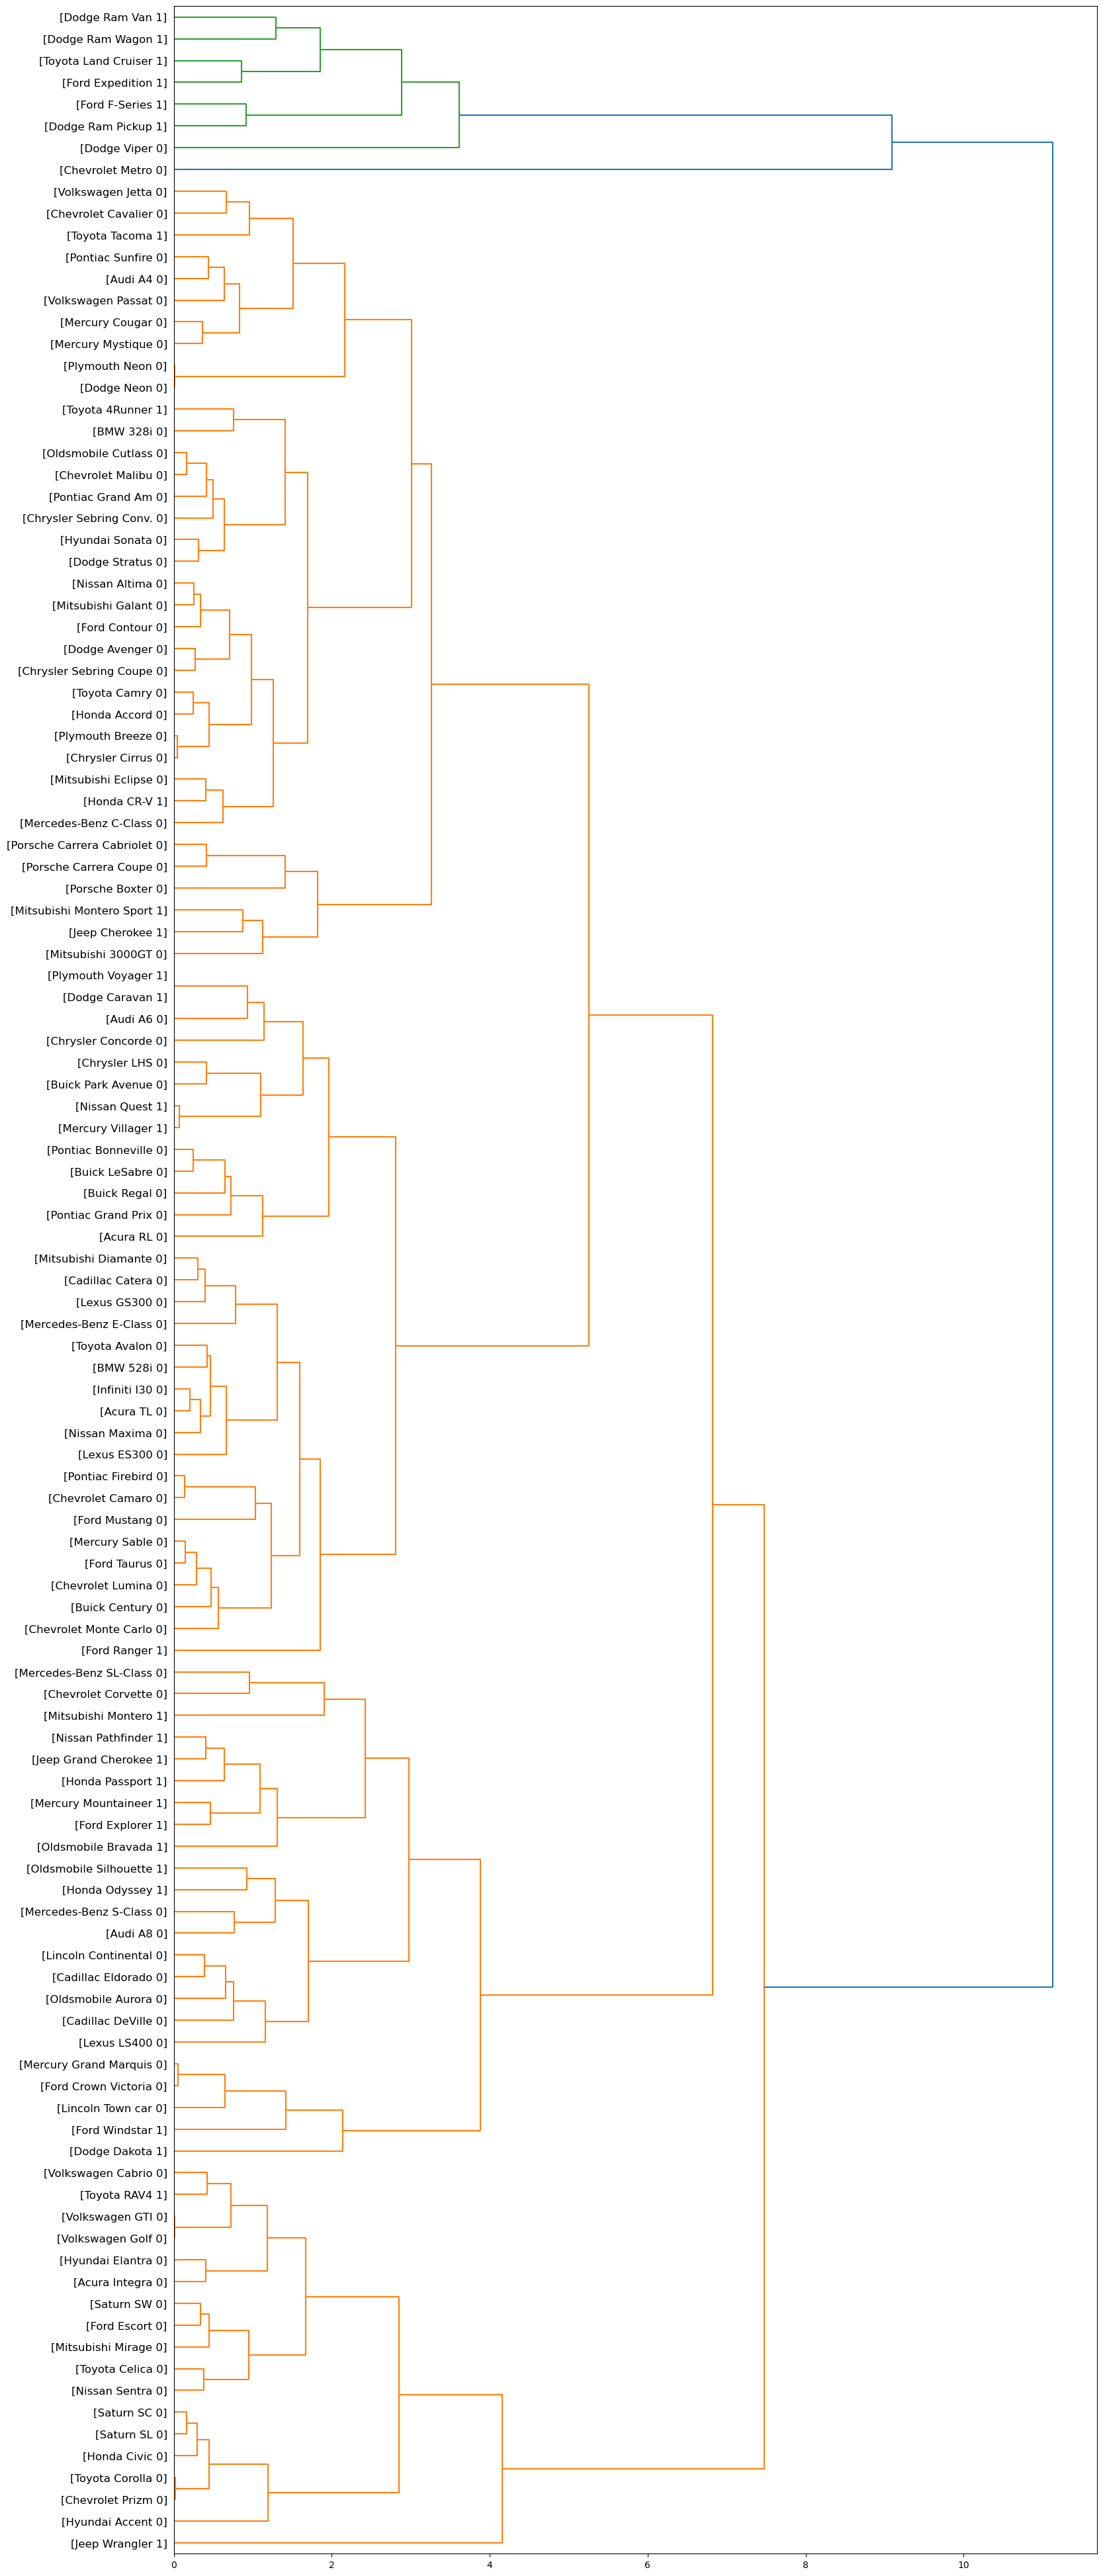

In [67]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s %s %s]' % (df['manufact'][id], df['model'][id], int(float(df['type'][id])) )
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

## Clustering using scikit-learn

In [68]:
from sklearn.metrics.pairwise import euclidean_distances
dist_matrix = euclidean_distances(feature_mtx, feature_mtx)
print(dist_matrix)

[[0.         0.585763   0.78573911 ... 0.28685109 0.25672507 0.19866125]
 [0.585763   0.         0.25892304 ... 0.36698373 0.66436916 0.62297526]
 [0.78573911 0.25892304 0.         ... 0.55085974 0.83285848 0.79502645]
 ...
 [0.28685109 0.36698373 0.55085974 ... 0.         0.41920634 0.35863999]
 [0.25672507 0.66436916 0.83285848 ... 0.41920634 0.         0.15212198]
 [0.19866125 0.62297526 0.79502645 ... 0.35863999 0.15212198 0.        ]]


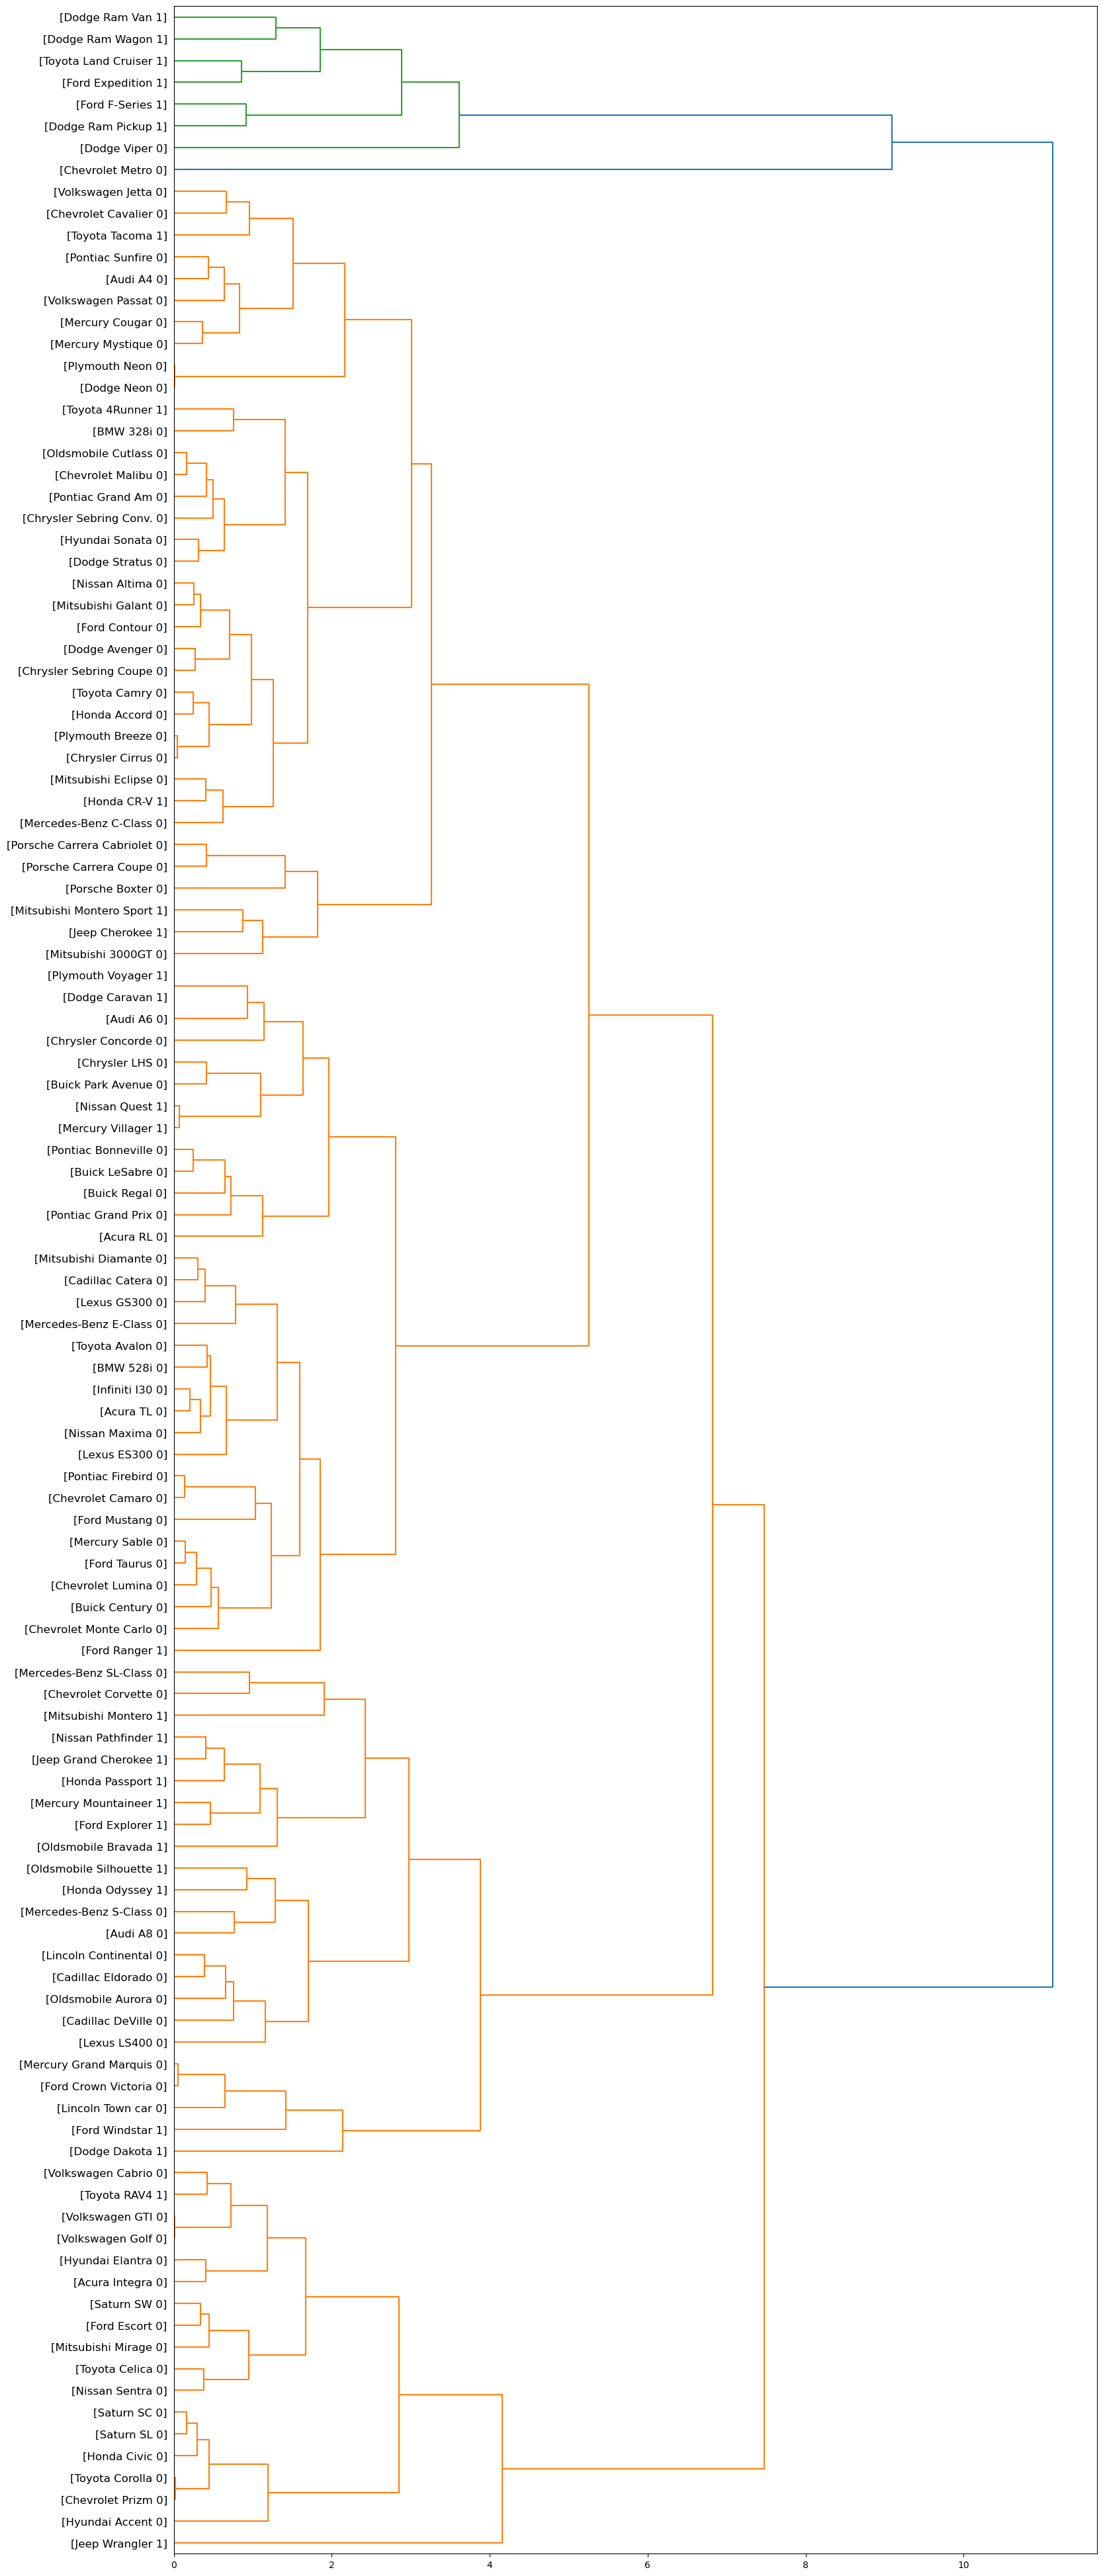

In [49]:
fig = pylab.figure(figsize=(18,50))
def llf(id):
    return '[%s %s %s]' % (df['manufact'][id], df['model'][id], int(float(df['type'][id])) )
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

In [69]:
agglom = AgglomerativeClustering(n_clusters = 6, linkage = 'complete')
agglom.fit(dist_matrix)
agglom.labels_

F:\Anaconda\Lib\site-packages\sklearn\cluster\_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


array([0, 2, 2, 4, 2, 1, 4, 2, 2, 2, 2, 2, 1, 1, 2, 4, 4, 2, 2, 2, 1, 0,
       5, 4, 4, 2, 4, 2, 4, 4, 4, 3, 3, 3, 3, 1, 2, 0, 2, 4, 2, 1, 1, 1,
       3, 2, 3, 0, 4, 4, 1, 1, 0, 0, 4, 2, 0, 4, 1, 2, 2, 1, 1, 1, 0, 4,
       4, 2, 4, 1, 4, 4, 4, 2, 1, 1, 2, 4, 2, 1, 1, 0, 4, 2, 2, 1, 4, 1,
       1, 1, 4, 4, 2, 4, 4, 2, 2, 2, 4, 4, 4, 0, 0, 0, 0, 4, 2, 0, 4, 0,
       4, 3, 0, 4, 4, 0, 0], dtype=int64)

We can add a new field to our dataframe to show the cluster of each row:


C:\Users\Erfan\AppData\Local\Temp\ipykernel_11564\270060311.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset.horsepow, subset.literperkm, s= subset.price*10, c=color, label='cluster'+str(label),alpha=0.5)


Text(0, 0.5, 'liter per km')

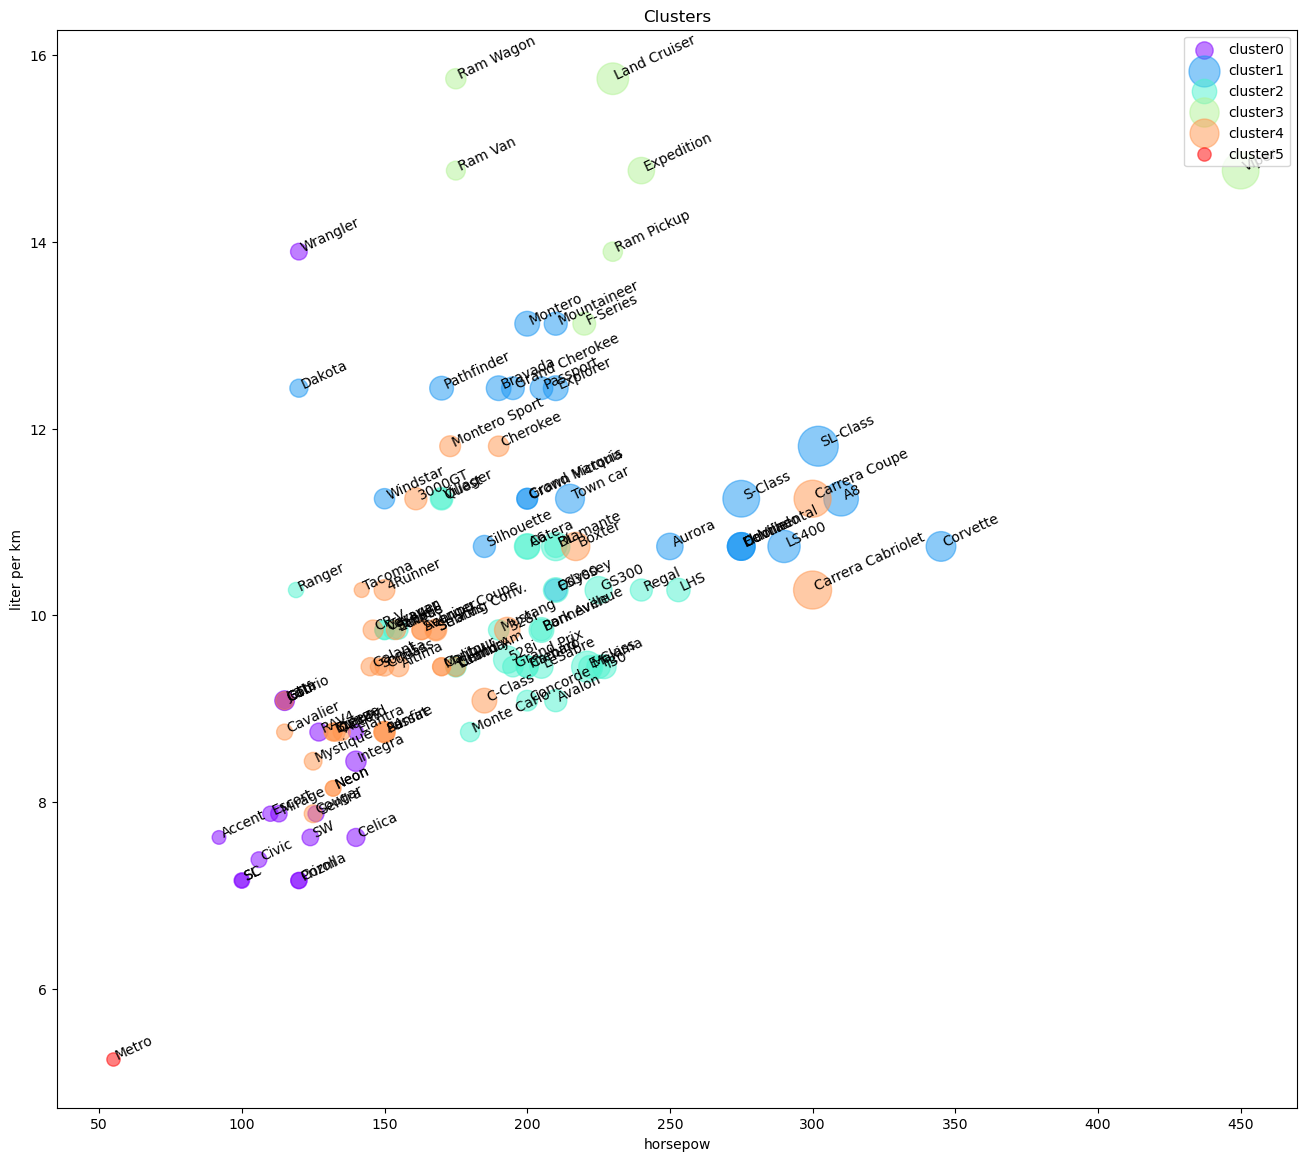

In [84]:
import matplotlib.cm as cm
n_clusters = max(agglom.labels_)+1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

# Create a figure of size 6 inches by 4 inches.
plt.figure(figsize=(16,14))

for color, label in zip(colors, cluster_labels):
    subset = df[df.cluster == label]
    for i in subset.index:
            plt.text(subset.horsepow[i], subset.literperkm[i],str(subset['model'][i]), rotation=25) 
    plt.scatter(subset.horsepow, subset.literperkm, s= subset.price*10, c=color, label='cluster'+str(label),alpha=0.5)
#    plt.scatter(subset.horsepow, subset.mpg)
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('liter per km')

As you can see, we are seeing the distribution of each cluster using the scatter plot, but it is not very clear where is the centroid of each cluster. Moreover, there are 2 types of vehicles in our dataset, "truck" (value of 1 in the type column) and "car" (value of 0 in the type column). So, we use them to distinguish the classes, and summarize the cluster. First we count the number of cases in each group:


In [77]:
df.groupby(['cluster','type'])['cluster'].count()

cluster  type
0        0.0     16
         1.0      2
1        0.0     12
         1.0     11
2        0.0     27
         1.0      5
3        0.0      1
         1.0      6
4        0.0     31
         1.0      5
5        0.0      1
Name: cluster, dtype: int64

In [81]:
agg_cars = df.groupby(['cluster','type'])[['horsepow','engine_s','literperkm','price']].mean()
agg_cars

horsepow  engine_s  literperkm      price
cluster type                                             
0       0.0   117.250000  1.850000    7.934637  14.330125
        1.0   123.500000  2.250000   11.323529  15.674000
1       0.0   267.666667  4.566667   11.041193  46.417417
        1.0   185.909091  3.518182   12.101422  26.856727
2       0.0   203.111111  3.303704    9.785538  27.750593
        1.0   151.800000  2.780000   10.491848  19.874800
3       0.0   450.000000  8.000000   14.765625  69.725000
        1.0   211.666667  4.483333   14.675551  29.024667
4       0.0   161.645161  2.451613    9.338760  23.390516
        1.0   160.200000  2.820000   10.802446  19.702600
5       0.0    55.000000  1.000000    5.250000   9.235000

It is obvious that we have 3 main clusters with the majority of vehicles in those.

**Cars**:

*   Cluster 1: with almost high mpg, and low in horsepower.

*   Cluster 2: with good mpg and horsepower, but higher price than average.

*   Cluster 3: with low mpg, high horsepower, highest price.

**Trucks**:

*   Cluster 1: with almost highest mpg among trucks, and lowest in horsepower and price.
*   Cluster 2: with almost low mpg and medium horsepower, but higher price than average.
*   Cluster 3: with good mpg and horsepower, low price.

Please notice that we did not use **type**  and **price** of cars in the clustering process, but Hierarchical clustering could forge the clusters and discriminate them with quite a high accuracy.


C:\Users\Erfan\AppData\Local\Temp\ipykernel_11564\714623340.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(subset.loc[i][0]+5, subset.loc[i][2], 'type='+str(int(i)) + ', price='+str(int(subset.loc[i][3]))+'k')
C:\Users\Erfan\AppData\Local\Temp\ipykernel_11564\714623340.py:6: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset.horsepow, subset.literperkm, s=subset.price*20, c=color, label='cluster'+str(label))


Text(0, 0.5, 'mpg')

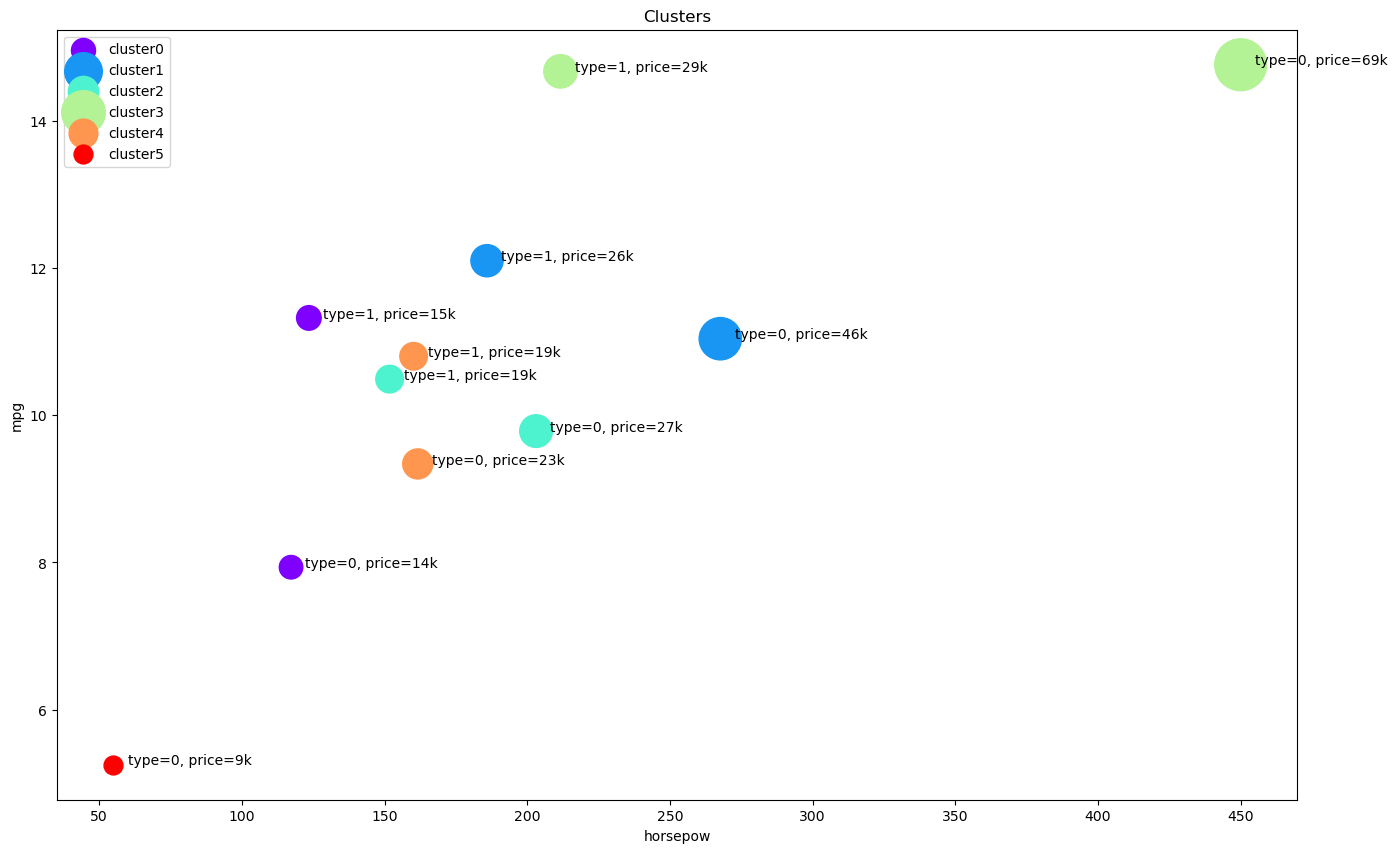

In [83]:
plt.figure(figsize=(16,10))
for color, label in zip(colors, cluster_labels):
    subset = agg_cars.loc[(label,),]
    for i in subset.index:
        plt.text(subset.loc[i][0]+5, subset.loc[i][2], 'type='+str(int(i)) + ', price='+str(int(subset.loc[i][3]))+'k')
    plt.scatter(subset.horsepow, subset.literperkm, s=subset.price*20, c=color, label='cluster'+str(label))
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg')
